In [59]:
## 加载数据，用SVM
## 导入包
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [107]:
df = pd.read_csv("Train_features.csv")
Train_features = np.array(df)

df = pd.read_csv("Test_features.csv")
Test_features = np.array(df)

df = pd.read_csv("train_label.csv")
train_label = np.array(df)

df = pd.read_csv("test_label.csv")
test_label = np.array(df)

/home/anichikage/anaconda3/envs/dram-py310/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


计算指标结果：
Acc: 78.74% 
Pre: 79.04% 
Recall: 77.54% 
F1-score: 78.28% 


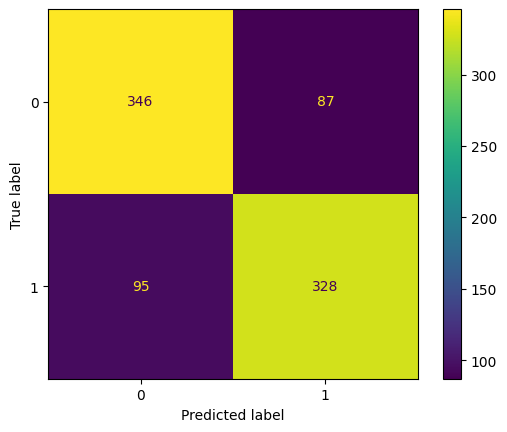

In [108]:
# 创建SVM模型
svm_model = SVC(kernel='rbf')
# CNN的输出为Tensor，需要转化为numpy输入给SVM
# 训练SVM
svm_model.fit(Train_features, train_label)

# 测试
predict_label = svm_model.predict(Test_features)

# 计算分类结果
acc = accuracy_score(test_label, predict_label) 
pre = precision_score(test_label, predict_label) 
recall = recall_score(test_label, predict_label) 
f1score = f1_score(test_label, predict_label) 
print('计算指标结果：\nAcc: %.2f%% \nPre: %.2f%% \nRecall: %.2f%% \nF1-score: %.2f%% ' % (100*acc,100*pre,100*recall,100*f1score))

## 绘制混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix(test_label, predict_label))
disp.plot()


In [62]:
## 查看FN样本，实际阳预测为阴的 test_label是1，predict_label是0的
test_label = test_label.reshape(-1)
FN_id = np.where((test_label == 1) & (predict_label == 0))
FN_id = np.array(FN_id)

In [63]:
# 测试集样本号
test_server_id = np.load("test_server_id.npy")
FN_server_id = test_server_id[FN_id]


In [64]:
FN_server_id = FN_server_id.reshape(-1)

In [65]:
## 返回去对应FN_Server
CE_data = np.load("./data_processed/data_mce3d.npy")
FN_server = CE_data[FN_server_id] # 95个FN_server


In [66]:
## 每个特征图都会有一个max_diff_row和max_diff_col
## 现在是要计算16个特征图中，最大的max_diff_row和max_diff_col
FN_server_one = FN_server[3]

max_diff_row = []
max_diff_col = []

for i in range(16):
    one = FN_server_one[i]

    # 找到非零值的索引
    non_zero_indices = np.argwhere(one != 0)

    # 获取最大行数和最大列数
    if non_zero_indices.size > 0:
        max_row = non_zero_indices[:, 0].max()
        min_row = non_zero_indices[:, 0].min()

        max_col = non_zero_indices[:, 1].max()
        min_col = non_zero_indices[:, 1].min()
    else:
        max_row, min_row, max_col, min_col = -1,-1,-1,-1  # 如果没有非零值

#     print("最大行数:", max_row)
#     print("最小行数:", min_row)

#     print("最大列数:", max_col)
#     print("最小列数:", min_col)
    max_diff_row1 = max_row - min_row
    max_diff_col1 = max_col - min_col
    max_diff_row = np.append(max_diff_row,max_diff_row1)
    max_diff_col = np.append(max_diff_col,max_diff_col1)

print(max_diff_row.max())
print(max_diff_col.max())

In [117]:
## 计算每个FN_server最大的行差和列差
def cal_maxdiff(FN_server): # FN_server是16x32x16的特征图
    max_diff_row = []
    max_diff_col = []
    # 依次计算每个特征图
    for i in range(16):
        one_channel = FN_server[i]
        # 找到非零值的索引
        non_zero_indices = np.argwhere(one_channel != 0)
        # 获取最大行数和最大列数
        if non_zero_indices.size > 0:
            max_row = non_zero_indices[:, 0].max()
            min_row = non_zero_indices[:, 0].min()

            max_col = non_zero_indices[:, 1].max()
            min_col = non_zero_indices[:, 1].min()
        else:
            max_row, min_row, max_col, min_col = -1,-1,-1,-1  # 如果没有非零值
    #     print("最大行数:", max_row)
    #     print("最小行数:", min_row)

    #     print("最大列数:", max_col)
    #     print("最小列数:", min_col)
        max_diff_row1 = max_row - min_row
        max_diff_col1 = max_col - min_col
        max_diff_row = np.append(max_diff_row, max_diff_row1)
        max_diff_col = np.append(max_diff_col, max_diff_col1)
        
    return max_diff_row.max(), max_diff_col.max()

In [73]:
max_diff_row, max_diff_col = cal_maxdiff(FN_server_one)
print(max_diff_row, max_diff_col)

0.0 15.0


In [118]:
FN_row_list = []
FN_col_list = []

for i in range(len(FN_server_id)):
    FN_server_one = FN_server[i]
    max_diff_row, max_diff_col = cal_maxdiff(FN_server_one)
    FN_row_list = np.append(FN_row_list, max_diff_row)
    FN_col_list = np.append(FN_col_list, max_diff_col)


NameError: name 'data' is not defined

In [87]:
print("95个FN样本的最大行差：\n",FN_row_list)
print("95个FN样本的最大列差：\n",FN_col_list)

95个FN样本的最大行差：
 [ 0.  0.  2.  0.  0.  0.  0.  0.  0. 19.  0. 16.  2.  3.  0.  0.  0.  0.
  0.  3.  0.  0. 16.  0. 16. 16. 16.  0. 16.  0.  0.  0.  0.  2.  1.  0.
  0.  1.  0.  0. 18.  1. 16.  0.  0.  0.  0.  0.  0.  0.  8.  0.  0. 16.
  0.  0.  0. 17.  0.  0.  0. 16.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.
  0. 30.  0. 17.  0.  0. 16.  0. 16.  0.  1.  0.  0.  0.  0.  0.  0. 17.
  0.  0.  2.  0. 16.]
95个FN样本的最大列差：
 [ 0.  0.  0. 15.  0. 15.  0.  4.  5.  0.  0.  0.  0.  0. 15. 15.  2.  0.
 14.  0.  0.  0. 15.  9. 13.  1.  0.  0. 15. 15.  2.  0.  0.  0.  0.  8.
 15. 15.  8.  0.  0.  8.  0. 15. 15.  0.  0.  0.  0.  0. 15. 15.  6. 12.
  0. 15. 14.  0.  5.  5.  7.  0.  0. 15.  1.  0.  0.  2. 15.  0.  0.  2.
  0. 12.  0.  0. 15. 15.  0.  0.  0.  6.  0.  0.  2.  0. 15.  0.  0.  0.
  0.  0. 15.  7.  0.]


In [81]:
# theta = np.arange(0.1, 1.1, 0.1)
# threshold = theta*32

In [89]:
row_threshold = 16
col_threshold = 8

In [97]:
num = sum((FN_row_list > 16) | (FN_col_list > 8)) # 最大行差大于16，或者最大列差大于8
print(num)

31


In [101]:
index = np.where((FN_row_list > 16) | (FN_col_list > 8))

In [116]:
## 计算指标
# 新的混淆矩阵
# 346  87
# 64  359

acc = (346+359)/(346+359+87+64)
recall = 359/(359+64)
pre = 359/(359+87)
f1 = 2*recall*pre/(recall+pre)
print('计算指标结果：\nAcc: %.2f%% \nPre: %.2f%% \nRecall: %.2f%% \nF1-score: %.2f%% ' % (100*acc,100*pre,100*recall,100*f1score))


计算指标结果：
Acc: 82.36% 
Pre: 80.49% 
Recall: 84.87% 
F1-score: 78.28% 
